# Environment creation/activation

In [1]:
import os

# PROJECT_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis"
# os.environ['PATH'] = "/sbin:/bin:/usr/bin:/usr/local/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin"
# os.environ['PATH'] = PROJECT_FOLDER+"/miniconda3/bin:" + os.environ['PATH'] 
os.environ['PATH'] 

'/data/students_home/amoscatelli/.local/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/envs/actionEnv/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/local/cuda/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin'

In [2]:

import os
# with tf.device("/GPU:0"):
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
import tensorflow as tf
tf.test.is_built_with_cuda()

True

In [6]:
from keras import backend as K
import tensorflow as tf
# import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

In [8]:
import keras
keras.__version__

'2.3.1'

Data preprocessing

In [9]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    labels = ["train_set", "val_set", "test_set"]
    for i,dataset in enumerate([train_set, val_set, test_set]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
        print("{} shape: {}".format(labels[i], dataset[0].shape))
        print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
    return train_set, val_set, test_set

def getZeroStatsForDataset(X):
    totalsize = sum([len(x)*34 for x in X])
    non_zero_elements = sum([np.count_nonzero(x) for x in X])
    zero_elements = totalsize - non_zero_elements
    return totalsize, zero_elements

In [10]:
# it removes the zeros from the dataset features taking for each video the closest non-zero value 
def removeZerosFromDataset(X):
    print("removing zeros from dataset")
    for i,video in enumerate(X):
        if sum([np.count_nonzero(frame==0) for frame in video])>0:
#             print("removing zeros from video", i)
            removeZerosFromVideo(video)
    return X
    
# return the closest non zero point for the passed point
def getClosestNonZeroCoordinate(frameIdx, point, features):
    for hop in range(1,len(features)):
        previousIdx = max(0, frameIdx-hop)
        nextIdx = min(len(features)-1, frameIdx+hop)
        if all(features[previousIdx][point] != 0):
            return features[previousIdx][point]
        if all(features[nextIdx][point] != 0):
            return features[nextIdx][point]
        
# it removes the zeros from the video features taking the closest non-zero values for each point
def removeZerosFromVideo(videoFeatures):
    # retrieving the index of the points which contain 0 values for each frame 
    zeroPoints = [list(set(np.where(frame == 0.)[0])) for frame in videoFeatures] 
    
    # concatenating the previous result with the frame index (discarding correct frames)
    zeroPointsCoordinates = [(i,p) for i,p in enumerate(zeroPoints) if len(p)>0]
    
    oldVideo = np.copy(videoFeatures)
    for frameIdx, pointCoordinates in zeroPointsCoordinates:
        for pointIdx in pointCoordinates:
            videoFeatures[frameIdx][pointIdx] = getClosestNonZeroCoordinate(frameIdx, pointIdx,oldVideo)

In [11]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels,encoder.classes_
    
from keras.preprocessing.sequence import pad_sequences

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
        maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    newXtrain = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXval = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXtest = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    
    ### stats ######################################
    labels = ["train set", "val set", "test set"]
    for i, dataset in enumerate([newXtrain, newXval, newXtest]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset)
        print("{} shape: {}".format(labels[i], dataset.shape))
        print("{} zero elements (after padding): {} ({:.2f}%)".format(labels[i],zero_elements,zero_elements*100/totalsize))
    
    return newXtrain, newXval, newXtest

In [12]:
def normaliseBeforePadding(X_train, X_val, X_test):
    trainAndVal = np.concatenate((X_train, X_val), axis=0)
    print("normalising train, val and test values BEFORE padding")
    trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
    trainStd = np.vstack(trainAndVal).std()
    normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
    normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
    normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])
    
    return normalized_X_train, normalized_X_val, normalized_X_test

In [13]:
def relativeToVideoCenter(X):
    print("Adapting the data to the center of each video")
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        X[i] = [frame-videoMean for frame in frames]

    return X

# Posenet predicts:
# 1 - nose 
# 2 - leftEye 
# 3 - rightEye 
# 4 - leftEar 
# 5 - rightEar

# 6 - leftShoulder 
# 7 - rightShoulder
# 8 - leftElbow 
# 9 - rightElbow 
# 10 - leftWrist
# 11 - rightWrist 

# 12 - leftHip 
# 13 - rightHip 
# 14 - leftKnee 
# 15 - rightKnee 
# 16 - leftAnkle
# 17 - rightAnkle

def relativeToUpperMiddleBottomCentersOfFrame(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            X[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
            X[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
            X[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
    return X

def relativeToUpperMiddleBottomCentersOfVideo(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM centers of each video")
    
    for i_video,frames in enumerate(X):        
        videoUpperMean = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMean = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMean = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = frame[:5] - videoUpperMean
            X[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMean
            X[i_video][i_frame][11:17] = frame[11:17] - videoBottomMean
    return X

def relativeTo3CentersOfVideoAbsolute(X):
    print("Adapting the data as the ABSOLUTE difference wrt to the TOP-MIDDLE-BOTTOM centers of each video")
    
    for i_video,frames in enumerate(X):        
        videoUpperMean = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMean = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMean = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = abs(frame[:5] - videoUpperMean)
            X[i_video][i_frame][5:11] = abs(frame[5:11] - videoMiddleMean)
            X[i_video][i_frame][11:17] = abs(frame[11:17] - videoBottomMean)
    return X

def relativeToFrameCenter(X):
    print("Adapting the data to the center of each frame")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

In [14]:
def relativeToNextFrame(X):
    print("Adapting the data to the next frame")
    newX = []
    for frames in X:
        motions = []
        for i in range(len(frames)-1):
            motions.append(np.array(frames[i+1])-np.array(frames[i]))
        newX.append(motions)
    return np.array(newX)
  

In [15]:
import math
def relativeToPointDistances(X):
    print("Adapting the data to the distances between points")
    newX = []
    for videoIdx,video in enumerate(X):
        if videoIdx % 100 == 0:
            print("{}/{} video done".format(videoIdx,len(X)))
        videoDistances = np.zeros((len(video),len(video[0]),len(video[0])-1))
        for fIdx, frame in enumerate(video):
            frameDistances = np.zeros((len(frame),len(frame)-1))
            for p1 in range(len(frame)):
                pointDistances = np.zeros(len(frame)-1)
                otherPoints = list(range(len(frame)))
                otherPoints.remove(p1) # in order to skip the difference with itself
                for idxP2, p2 in enumerate(otherPoints):
                    dist = math.sqrt((frame[p2][0] - frame[p1][0])**2 + (frame[p2][1] - frame[p1][1])**2)
                    pointDistances[idxP2] = dist
                frameDistances[p1] = pointDistances
            videoDistances[fIdx] = frameDistances
        newX.append(videoDistances)
    return np.array(newX)

In [16]:
def preprocessData(train_set, val_set, test_set, normalize: bool, preprocess_functions = None):
    X_train, X_val, X_test = train_set[0], val_set[0], test_set[0]
    # one hot encoding
    y_train, _ = one_hot_encoding(train_set[1])
    y_val, _ = one_hot_encoding(val_set[1])
    y_test, _ = one_hot_encoding(test_set[1])

    # preprocess
    if preprocess_functions is not None:
        for preprocess_function in preprocess_functions:
            # in case of tuples like (function, param1, param2)
            if not callable(preprocess_function): 
                preprocess_function = preprocess_function[0]
            X_train = preprocess_function(X_train)
            X_val = preprocess_function(X_val)
            X_test = preprocess_function(X_test)
    
    # normalize
    if normalize:
        X_train, X_val, X_test = normaliseBeforePadding(X_train, X_val, X_test)
    
    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)
    
    ## reshaping ###
    finalDim = X_train.shape[2] * X_train.shape[3]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], finalDim) 
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], finalDim) 
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], finalDim)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
import scipy
from scipy import signal

# builder function which returs a Savitzky-Golay smoother function with the passed arguments
def smoothingPoints(window, order):
    movingWindow = window
    polynomialOrder = order
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def smooth(X):
        for vidIdx, video in enumerate(X):
            if vidIdx % 500 == 0:
                print("smooting video {}/{}".format(vidIdx,len(X)))
            for p in range(len(X[0][0])): # X[0][0] == 17 -> the number of points
                x, y = zip(*[(f[p][0], f[p][1]) for f in video])
                
                #     Savitzky-Golay
                smooth_x = signal.savgol_filter(x, movingWindow, polynomialOrder)
                smooth_y = signal.savgol_filter(y, movingWindow, polynomialOrder)
                
                # placing the smoothed series
                for i,frame in enumerate(video):
                    frame[p] = [smooth_x[i], smooth_y[i]]
        return X
        
    return smooth, window, order

# Setting data

In [18]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Senesi/"
SAVED_MODEL_FOLDER += "Cross_view/"
# MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
DROPOUT = 0.2 # 0 == OFF
RECURRENT_DROPOUT = 0.2 # 0 == OFF
LOAD_FROM_PREVIOUS_DROPOUT = [0.3, 0.4, 0.5] # [] == don't load
LSTM_LAYERS = 1
PREPROCESS_FUNCTION_TO_TEST = [
    ([removeZerosFromDataset, relativeToUpperMiddleBottomCentersOfVideo], True)
    ,([removeZerosFromDataset, relativeToNextFrame], True)
    ,([removeZerosFromDataset, relativeToPointDistances], True)
    ,([removeZerosFromDataset, relativeTo3CentersOfVideoAbsolute], True)
    
    
#     ,([removeZerosFromDataset, smoothingPoints(29, 9), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29, 9), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29, 9), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29, 9), relativeTo3CentersOfVideoAbsolute], True)
    
    
    
#     ([removeZerosFromDataset, relativeTo3CentersOfVideoAbsolute], True)
#     ,([removeZerosFromDataset, relativeTo3CentersOfVideoAbsolute], False)
#     ,([removeZerosFromDataset, smoothingPoints(29, 9), relativeTo3CentersOfVideoAbsolute], True)
#     ,([removeZerosFromDataset, smoothingPoints(29, 7), relativeTo3CentersOfVideoAbsolute], True)
#     ,([removeZerosFromDataset, smoothingPoints(29, 5), relativeTo3CentersOfVideoAbsolute], True)
    
#     ([removeZerosFromDataset, relativeToUpperMiddleBottomCentersOfVideo], True)
#     ([removeZerosFromDataset, smoothingPoints(29,9), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ([removeZerosFromDataset, smoothingPoints(29,8), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,7), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,6), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,5), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,4), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,3), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,2), relativeToUpperMiddleBottomCentersOfVideo], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,1), relativeToUpperMiddleBottomCentersOfVideo], True)
    
    
#     ,([removeZerosFromDataset, relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,9), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,8), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,7), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,6), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,5), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,4), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,3), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,2), relativeToNextFrame], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,1), relativeToNextFrame], True)
    
    
#     ,([removeZerosFromDataset, relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,9), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,8), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,7), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,6), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,5), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,4), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,3), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,2), relativeToPointDistances], True)
#     ,([removeZerosFromDataset, smoothingPoints(29,1), relativeToPointDistances], True)
]

print("LSTM_LAYERS:", LSTM_LAYERS)
SAVED_MODEL_FOLDER 

LSTM_LAYERS: 1


'/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/'

## sequential trainings

In [19]:
def getSaveFileName(modelName,preprocess_functions,normalize,numberOfLSTMLayers, dropOut, recurrentDropOut):
    saveFileName = modelName+"-{}L".format(numberOfLSTMLayers+1)
    if preprocess_functions is not None:
        for function in preprocess_functions:
            if callable(function):
                saveFileName += "-{}".format(function.__name__) 
            else:
                for component in function:
                    if callable(component):
                        saveFileName += "-{}".format(component.__name__) # in case it's a function
                    else: 
                        saveFileName += "-{}".format(component) # in case it's a parameter value
                

    saveFileName += "-drop-"+str(dropOut)
    saveFileName += "-rec_drop-"+str(recurrentDropOut)
        
    if normalize:
        saveFileName += "-norm"
    
    return saveFileName

In [20]:
from sklearn.metrics import accuracy_score
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = None):
    if label_order == None:
        label_order = list(range(len(y_val[0])))
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred

In [ ]:
import dill
from keras import models,layers
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import random
from os import scandir
from os.path import exists

BATCH_SIZE = 128
EPOCHS = 3000 #the earlystop will stop the training
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=130, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)
callbacks_list = [earlyStop]

for i, (preprocess_functions, normalize) in enumerate(PREPROCESS_FUNCTION_TO_TEST):
    
    alreadyTrainedModel = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path.endswith(".h5")]
    
    ### Determining save file name ###
    saveFileName = getSaveFileName(MODEL_NAME,preprocess_functions,normalize,LSTM_LAYERS, DROPOUT, RECURRENT_DROPOUT)
        
    print("######## {}/{} - {} ########".format(i+1, len(PREPROCESS_FUNCTION_TO_TEST), saveFileName))
    
    if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
        print("### already done! ####")
        continue
    else:
        #to avoid that someone else will start the same fitting
        print("touching",SAVED_MODEL_FOLDER+saveFileName+".h5")
        modelFileName = saveFileName+".h5"
        !touch $SAVED_MODEL_FOLDER$modelFileName
        print("## To be saved in [...]{} ###".format(SAVED_MODEL_FOLDER[54:]))
        
    ### Loading dataset ###
    if SAVED_MODEL_FOLDER.endswith("Senesi/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
    elif SAVED_MODEL_FOLDER.endswith("Cross_subject/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"
    elif SAVED_MODEL_FOLDER.endswith("Cross_view/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"
    elif SAVED_MODEL_FOLDER.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
    else:
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
        
    print("#### Loading dataset: ", datasetName)
    train_set, val_set, test_set = getData(datasetName)
#     print("YOU'RE NOT LOADING THE DATASET")
    
    ### Preprocess ###
#     train_set[0] = train_set[0][:50]
#     train_set[1] = train_set[1][:50]
#     val_set[0] = val_set[0][:50]
#     val_set[1] = val_set[1][:50]
#     test_set[0] = test_set[0][:50]
#     test_set[1] = test_set[1][:50]
#     print("YOU'RE CUTTING THE DATASETS")
    
    X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, 
                                                                    val_set, 
                                                                    test_set, 
                                                                    normalize, 
                                                                    preprocess_functions)
#     print("YOU'RE NOT DOING THE PREPROCESS")
    
    ### Defining model ###
    inputDim = (X_train.shape[1], X_train.shape[2])
    outputLen = len(y_train[0])
    
    
    model = models.Sequential()
    
    if LSTM_LAYERS == 1:
        model.add(LSTM(64, dropout = DROPOUT, recurrent_dropout = RECURRENT_DROPOUT, input_shape=inputDim))
    else:       
        model.add(LSTM(64, dropout = DROPOUT, recurrent_dropout = RECURRENT_DROPOUT, input_shape=inputDim, return_sequences=True))
        for layerIdx in range(2, LSTM_LAYERS):
            model.add(LSTM(64, dropout = DROPOUT, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
        model.add(LSTM(64, dropout = DROPOUT, recurrent_dropout = RECURRENT_DROPOUT))    
    
    model.add(layers.Dense(outputLen, activation='softmax'))
    
    model.compile(
              optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        
        
    ### Loading weights from previous model trained with an higher dropout rate
    loadedFromPreviousModel = False
    if (DROPOUT > 0 or RECURRENT_DROPOUT > 0) and LOAD_FROM_PREVIOUS_DROPOUT:
        for prev_dropOut in LOAD_FROM_PREVIOUS_DROPOUT:
            previousModelName = getSaveFileName(MODEL_NAME, preprocess_functions, normalize, LSTM_LAYERS, prev_dropOut, prev_dropOut)
            if exists(SAVED_MODEL_FOLDER+previousModelName+".h5"):
                print("#### Loading weights from",previousModelName)
                model.load_weights(SAVED_MODEL_FOLDER+previousModelName+".h5")
                loadedFromPreviousModel = True
                break
         
        
    ## Fit ###    
    model_history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=callbacks_list,
                        validation_data=(X_val, y_val)
                       )

    ### save model
    model.save(SAVED_MODEL_FOLDER+saveFileName+".h5")
    
    ### save history and preprocess functions
    env_functions = [one_hot_encoding, 
                      normaliseBeforePadding, 
                      paddingTrainValTest, 
                      getClosestNonZeroCoordinate,
                      removeZerosFromVideo,
                      getZeroStatsForDataset,
                      preprocessData,
                     ]

    
    info_to_save = {"history":model_history, 
                     "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                     "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}
    
    if loadedFromPreviousModel:
        info_to_save["loaded_from"] = previousModelName
    
    with open(SAVED_MODEL_FOLDER+saveFileName+".pickle","wb") as handle:
        pickle.dump(info_to_save, handle) 
        print("## Saved in {} ###\n\n".format(SAVED_MODEL_FOLDER+saveFileName+".pickle"))
        
        
    
    ### Evaluating model
    val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test)
    print("test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

    ### Saving results
    if exists(SAVED_MODEL_FOLDER+"summaryResults.pickle"):
        print("Loading previous results...")
        with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
                results = pickle.load(handle)
    else:
        results = []
            
    results.append({"val_acc": val_acc, 
                    "test_acc":test_acc, 
                    "model_name": saveFileName, 
                    "y_val_true": y_val_true,
                    "y_val_pred": y_val_pred,
                    "y_test_true": y_test_true,
                    "y_test_pred": y_test_pred 
                   })

    print("Dumping results...")
    with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","wb") as handle:
        pickle.dump(results, handle)
#     print("YOU ARE NOT SAVING THE EVALUATION")
    
print("DONE!")

######## 1/4 - keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.2-rec_drop-0.2-norm ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.2-rec_drop-0.2-norm.h5
## To be saved in [...]/savedModels/Cross_view/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW-dataset.pickle
train_set shape: (6572,)
train_set zero elements: 18394/16665780 (0.11%)
val_set shape: (1644,)
val_set zero elements: 2006/4164082 (0.048%)
test_set shape: (4108,)
test_set zero elements: 952/10400634 (0.0092%)
classes order: ['1' '2' '23' '24' '26' '27' '31' '35' '49' '6' '7' '8' '9']
classes order: ['1' '2' '23' '24' '26' '27' '31' '35' '49' '6' '7' '8' '9']
classes order: ['1' '2' '23' '24' '26' '27' '31' '35' '49' '6' '7' '

In [5]:
def cleanForExcel(text):
    text = text.replace(".h5","").replace(".",",").replace("PoseNet-101","PoseNet").replace("keypoint_rcnn_X_101_32x8d_FPN_3x","Detectron2")
    return text

In [12]:
#Show results
import pickle
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
resultToPrint = ["{:.3f} {:.3f} {}".format(v["val_acc"]*100,v["test_acc"]*100,v["model_name"]) for v in loadedResults 
                 if "drop" in v["model_name"]
                ]
resultToPrint = [cleanForExcel(t) for t in resultToPrint]
print(*resultToPrint,sep="\n")

89,016 86,622 Detectron2-2L-removeZerosFromDataset-smooth-29-9-relativeToNextFrame-drop-0,5-rec_drop-0,5-norm
88,215 85,953 Detectron2-2L-removeZerosFromDataset-relativeToNextFrame-drop-0,5-rec_drop-0,5-norm
92,334 84,699 Detectron2-2L-removeZerosFromDataset-relativeToPointDistances-drop-0,5-rec_drop-0,5-norm
88,501 83,640 Detectron2-2L-removeZerosFromDataset-relativeTo3CentersOfVideoAbsolute-drop-0,5-rec_drop-0,5-norm
89,645 83,584 Detectron2-2L-removeZerosFromDataset-smooth-29-9-relativeToUpperMiddleBottomCentersOfVideo-drop-0,5-rec_drop-0,5-norm
90,675 83,194 Detectron2-2L-removeZerosFromDataset-smooth-29-9-relativeToPointDistances-drop-0,5-rec_drop-0,5-norm
85,755 80,881 Detectron2-2L-removeZerosFromDataset-smooth-29-9-relativeTo3CentersOfVideoAbsolute-drop-0,5-rec_drop-0,5-norm
14,703 15,190 Detectron2-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0,5-rec_drop-0,5-norm


## display model history

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-drop-0.5-rec_drop-0.5-norm.pickle


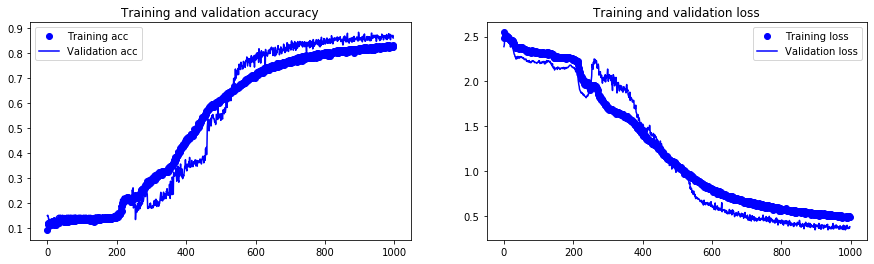

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeTo3CentersOfVideoAbsolute-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeTo3CentersOfVideoAbsolute-drop-0.5-rec_drop-0.5-norm.pickle


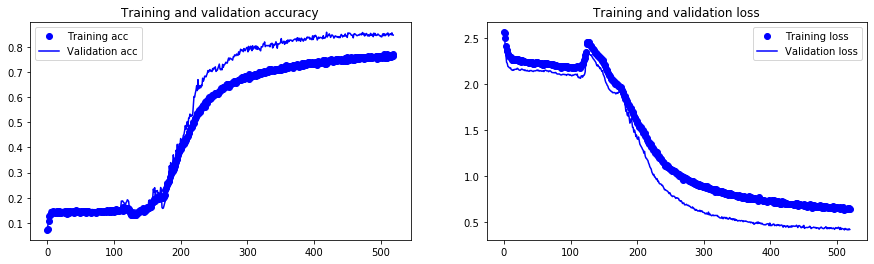

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeTo3CentersOfVideoAbsolute-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeTo3CentersOfVideoAbsolute-drop-0.5-rec_drop-0.5-norm.pickle


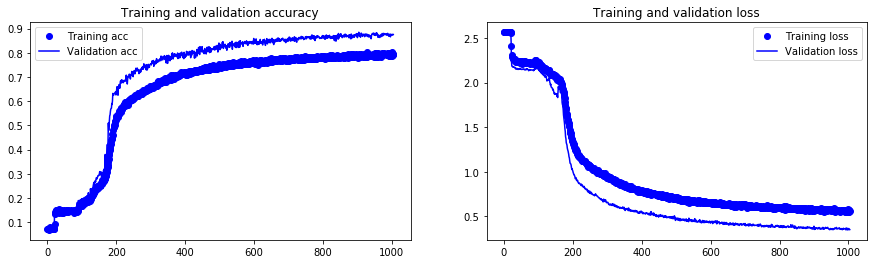

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeToNextFrame-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeToNextFrame-drop-0.5-rec_drop-0.5-norm.pickle


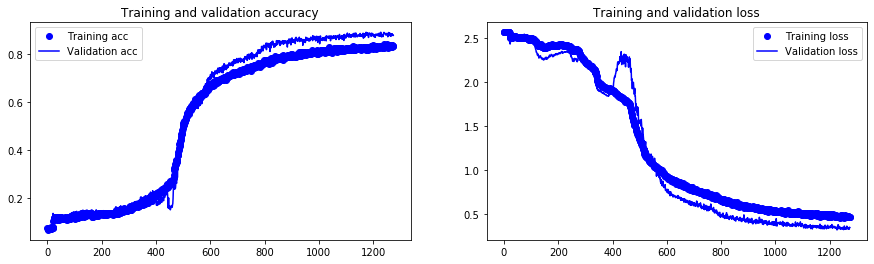

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.5-rec_drop-0.5-norm.pickle


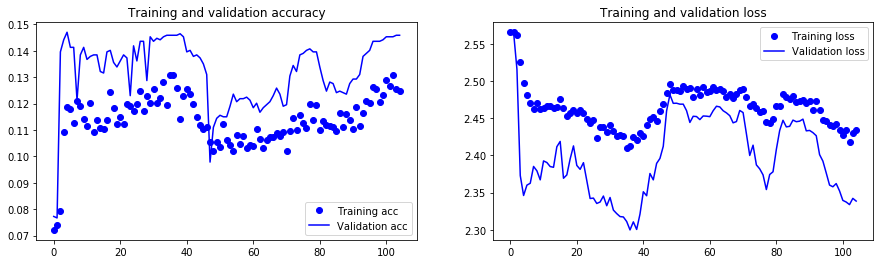

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToPointDistances-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToPointDistances-drop-0.5-rec_drop-0.5-norm.pickle


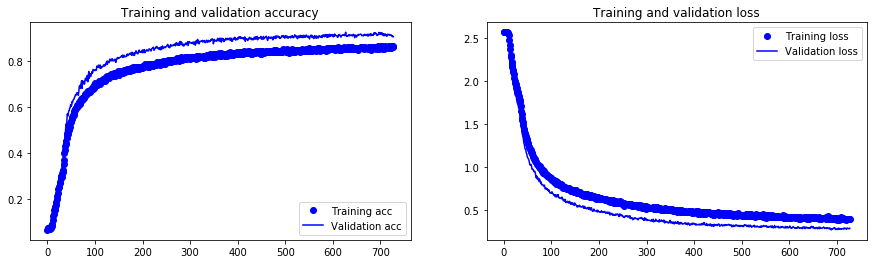

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeToPointDistances-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeToPointDistances-drop-0.5-rec_drop-0.5-norm.pickle


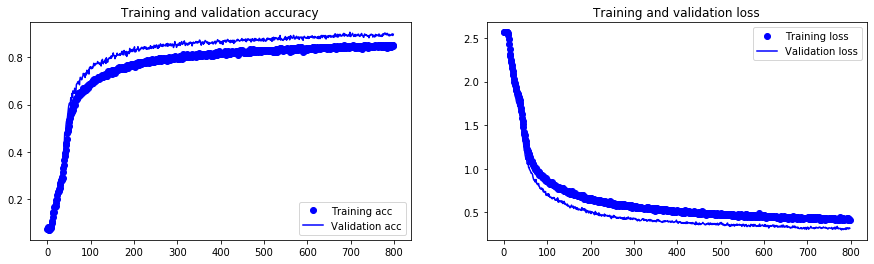

Loading keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeToUpperMiddleBottomCentersOfVideo-drop-0.5-rec_drop-0.5-norm.pickle
################################################################################################
keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-smooth-29-9-relativeToUpperMiddleBottomCentersOfVideo-drop-0.5-rec_drop-0.5-norm.pickle


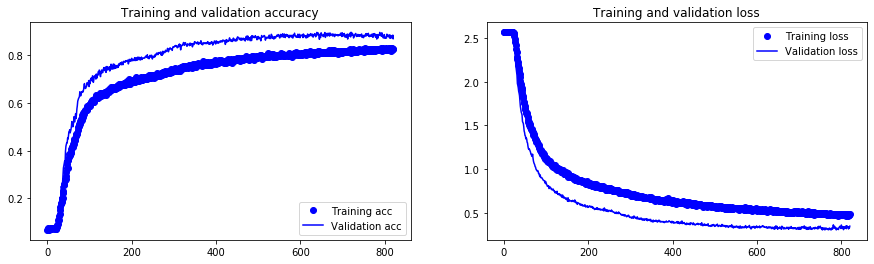

In [13]:
import matplotlib.pyplot as plt 
import pickle
from os import scandir
# from os.path import exists


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "1-layer-LSTM-64-Dense-8(with-PoseNet-101-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_subject/"

historiesToVisualize = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path.endswith(".pickle") and "drop" in f.name]
for historyPath in historiesToVisualize:
    # modelToVisualize = "keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm.pickle"
    # modelToVisualize = "keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm.pickle"
#     modelToVisualize = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-drop-0.4-rec_drop-0.4-norm.pickle"
#     with open(SAVED_MODEL_FOLDER+modelToVisualize,'rb') as file_in:
    print("Loading",historyPath.name)
    with open(historyPath,"rb") as file_in:
        r = pickle.load(file_in)

    model_history = r["history"]
    print("################################################################################################")
    # print(r["model_name"])
    print(historyPath.name)
    # print("Test acc: {:.3f}%  Val acc: {:.3f}%".format(r["test_acc"]*100,r["val_acc"]*100))

    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize = (15,4))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    ax1.legend()

    #     plt.figure()
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    ax2.legend()

    plt.show()

In [26]:
import matplotlib.pyplot as plt 
import pickle
from os import scandir
# from os.path import exists


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "1-layer-LSTM-64-Dense-8(with-PoseNet-101-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/"
SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Cross_view/"

historiesToVisualize = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path.endswith(".pickle") and "drop" in f.name]
for historyPath in historiesToVisualize[:1]:
    # modelToVisualize = "keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm.pickle"
    # modelToVisualize = "keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm.pickle"
#     modelToVisualize = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-drop-0.4-rec_drop-0.4-norm.pickle"
#     with open(SAVED_MODEL_FOLDER+modelToVisualize,'rb') as file_in:
    print("Loading",historyPath)
    with open(historyPath,"rb") as file_in:
        r = pickle.load(file_in)

Loading <DirEntry 'keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-drop-0.5-rec_drop-0.5-norm.pickle'>



In [30]:
modelHist = r['history']

In [41]:
modelHist.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [43]:
lstmLayer = modelHist

In [49]:
modelHist.history

{'accuracy': [0.12032967,
  0.12106227,
  0.11904762,
  0.11300366,
  0.11941392,
  0.11593407,
  0.12197802,
  0.12069597,
  0.12216117,
  0.11721612,
  0.12014652,
  0.12069597,
  0.11630037,
  0.12326007,
  0.113919415,
  0.12014652,
  0.11575092,
  0.11959707,
  0.124725275,
  0.113919415,
  0.11739927,
  0.12692308,
  0.11886447,
  0.12142857,
  0.11666667,
  0.11904762,
  0.11703297,
  0.124542125,
  0.11776557,
  0.124908425,
  0.124725275,
  0.17490843,
  0.20201465,
  0.2043956,
  0.1989011,
  0.20659341,
  0.1952381,
  0.1959707,
  0.17802198,
  0.18571429,
  0.1915751,
  0.18498169,
  0.18736264,
  0.18736264,
  0.18699634,
  0.18296704,
  0.18241759,
  0.17875458,
  0.17600733,
  0.18406594,
  0.17857143,
  0.18168499,
  0.18315019,
  0.18003663,
  0.18864469,
  0.18443224,
  0.18095239,
  0.18150184,
  0.18443224,
  0.18040293,
  0.18186814,
  0.18369964,
  0.18681319,
  0.17838828,
  0.18736264,
  0.17967033,
  0.18534799,
  0.18443224,
  0.18351649,
  0.18241759,
  0.179

In [47]:
lstmLayer. = 0.4

AttributeError: can't set attribute

# AREA TEST

## Testing relativeToNextFrameFunction

In [23]:
MODEL_NAME
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 0/13984574 (0.0%)
val_set shape: (1365,)
val_set zero elements: 0/3509310 (0.0%)
test_set shape: (759,)
test_set zero elements: 0/1973564 (0.0%)


In [24]:
set_to_Test = train_set[0][:3]

In [26]:
len(set_to_Test)

3

In [32]:
differences = relativeToNextFrame(train_set[0])

Adapting the data to the next frame


In [36]:
train_set[0][0][:2]

[[[1007.7985, 325.73468],
  [1006.3635, 315.66202],
  [1002.0584, 315.66202],
  [961.87787, 322.85678],
  [979.09814, 318.53992],
  [956.1378, 376.0981],
  [969.053, 377.53705],
  [983.4032, 465.3133],
  [974.793, 460.99646],
  [1007.7985, 534.3832],
  [1006.3635, 532.9442],
  [961.87787, 528.6273],
  [964.74786, 528.6273],
  [957.5728, 646.62164],
  [961.87787, 648.0606],
  [954.7027, 747.3485],
  [959.0078, 755.9822]],
 [[1008.1875, 325.57687],
  [1006.7477, 315.524],
  [1002.42804, 315.524],
  [959.2314, 322.70465],
  [977.9499, 321.2685],
  [957.79144, 375.84143],
  [967.8706, 377.27756],
  [967.8706, 460.5731],
  [977.9499, 462.00922],
  [1016.82684, 533.8157],
  [1016.82684, 533.8157],
  [959.2314, 530.9434],
  [963.55096, 530.9434],
  [956.3515, 648.7061],
  [962.11115, 650.1422],
  [954.9117, 743.49066],
  [957.79144, 754.97974]]]

In [40]:
# trainAndVal = np.concatenate((X_train, X_val), axis=0)
print("normalising train, val and test values BEFORE padding")
trainMean = np.vstack(differences).mean() # the mean and std must be calculated only on the training data
trainStd = np.vstack(differences).std()
trainMean,trainStd

normalising train, val and test values BEFORE padding


(-0.056956816, 10.33186)

In [31]:
len(differences[0]),len(set_to_Test[0])

(52, 53)

## Smoothing test

In [35]:
MODEL_NAME = "PoseNet-101"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 58106/13984574 (0.42%)
val_set shape: (1365,)
val_set zero elements: 15980/3509310 (0.46%)
test_set shape: (759,)
test_set zero elements: 9588/1973564 (0.49%)


doing video 0
doing video 1


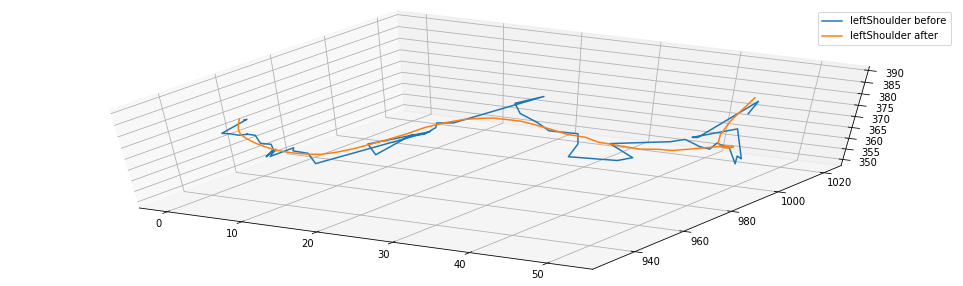

In [36]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p]+" before")
    
    smoothingPoints(29,5)[0](train_set[0])
    
    x2, y2 = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z2 = np.arange(len(x))
    ax.plot(z2,y2,x2,label=legend[p]+" after")
    
    ax.legend()

plt.show()
  

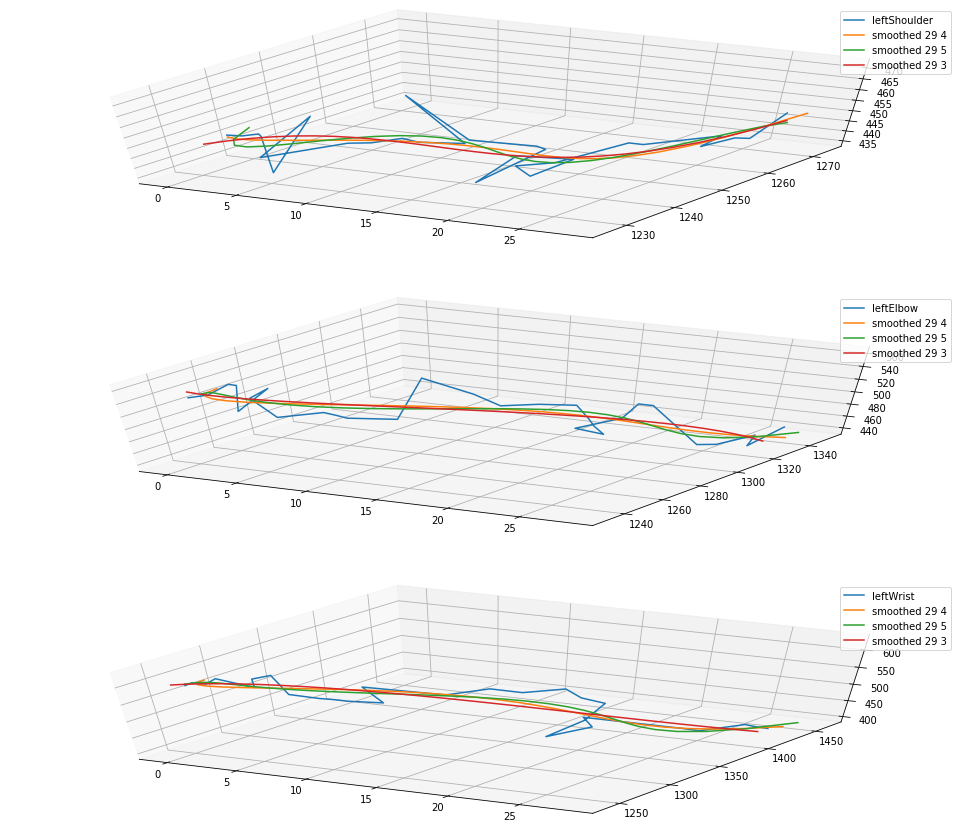

In [91]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p])
    
    smooth_y=signal.savgol_filter(y, window, order) 
    smooth_x=signal.savgol_filter(x, window, order)
    ax.plot(z,smooth_y,smooth_x,label="smoothed {} {}".format(window,order))
    
    
    ax.legend()

plt.show()
  

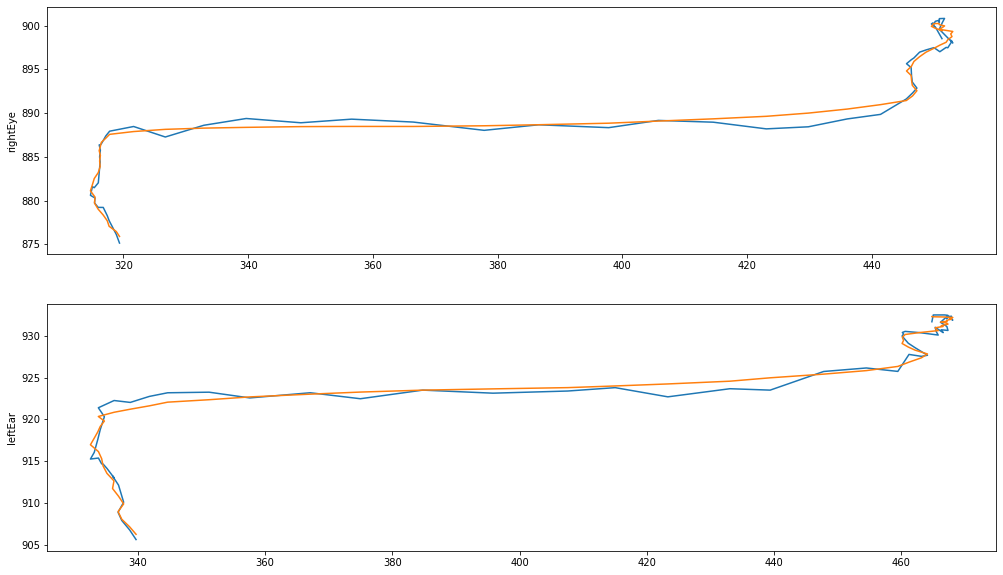

In [302]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
listOfPoints = [2,3]
fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)
fig.set_size_inches((17,len(listOfPoints)*5))
for i, p in enumerate(listOfPoints):
    axes[i].set_ylabel(legend[p])
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    ts = Series(y, index=x)
    # ts = ts.cumsum()
    ts.plot(ax=axes[i])
    
    smooth_y=signal.savgol_filter(ts.get_values(),
                           29, # window size used for filtering
                           3), # order of fitted polynomial

    ts2 = Series(smooth_y[0], index=x)

    ts2.plot(ax=axes[i])

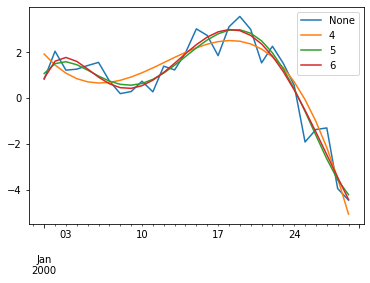

In [115]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal


# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(29), index=date_range('1/1/2000', periods=29))
ts = ts.cumsum()
ts.plot()

y1=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       4) # order of fitted polynomial  
ts2 = Series(y1, index=date_range('1/1/2000', periods=29))
ts2.plot(label="4")


y2=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       5) # order of fitted polynomial
ts3 = Series(y2, index=date_range('1/1/2000', periods=29))
ts3.plot(label="5")


y3=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       6) # order of fitted polynomial
ts4 = Series(y3, index=date_range('1/1/2000', periods=29))

ts4.plot(label="6")
plt.legend()

In [150]:
getSaveFileName(MODEL_NAME,preprocess_functions,normalize)

PoseNet-101-smooth
PoseNet-101-smooth-53
PoseNet-101-smooth-53-3


In [14]:
for i, (specific_function, normalize) in enumerate(COMBINATIONS_TO_TEST):
    print(i,specific_function,normalize)

0 <function relativeToNextFrame at 0x7fab0effd7b8> True
1 <function relativeToUpperMiddleBottomCentersOfVideo at 0x7fab0effdea0> True
2 <function relativeToVideoCenter at 0x7fab0fd56e18> True


## load values

In [ ]:
import dill
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences

MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)


with open('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/PoseNet-101-relativeToNextFrame.pickle',"rb") as handle:
    res = pickle.load(handle)
    
loaded_functions = [dill.loads(x) for x in res["prep_fun_DILL"]]

one_hot_encoding = loaded_functions[0]
normaliseBeforePadding = loaded_functions[1]
paddingTrainValTest = loaded_functions[2]
preprocessData = loaded_functions[3]
relativeToNextFrame = loaded_functions[4]

## old method

In [ ]:
## Determining save file name
saveFileName = MODEL_NAME
for fun in PREPROCESS_FUNCTIONS:
    saveFileName += "-{}".format(fun.__name__)

if NORMALIZE:
    saveFileName += "-norm"

saveFileName +=".h5"
saveFileName

In [9]:
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)

number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)


## Preprocessing

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, NORMALIZE, PREPROCESS_FUNCTIONS)

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
number of zeros train (after padding):		27798672 - 66.55%
number of zeros validation (after padding):	6951708 - 66.57%
number of zeros test (after padding):		3883446 - 66.88%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)


In [ ]:
## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

# Defining model

In [13]:
from keras import models,layers
from keras.layers import LSTM
BATCH_SIZE = 32
length_in_frames = X_train.shape[1]
model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', input_shape=(BATCH_SIZE, length_in_frames, 17 * 2)))
model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

EPOCHS = 3000 #the earlystop will stop the training
model_history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
#                     validation_split=0.2
                    validation_data=(X_val, y_val)
                   )

model.save(SAVED_MODEL_FOLDER+saveFileName)


Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0805 - accuracy: 0.1183 - val_loss: 2.0788 - val_accuracy: 0.1275
Epoch 2/3000
5460/5460 [==============================] - 22s 4ms/step - loss: 2.0799 - accuracy: 0.1227 - val_loss: 2.0786 - val_accuracy: 0.1275
Epoch 3/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0799 - accuracy: 0.1238 - val_loss: 2.0769 - val_accuracy: 0.1289
Epoch 4/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.9958 - accuracy: 0.1764 - val_loss: 1.8582 - val_accuracy: 0.2198
Epoch 5/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8107 - accuracy: 0.2269 - val_loss: 1.7355 - val_accuracy: 0.2454
Epoch 6/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.6389 - accuracy: 0.2936 - val_loss: 1.6151 - val_accuracy: 0.2828
Epoch 7/3000
5460/5460 [==============================] - 19s 4ms/ste

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
max(acc),max(val_acc),min(loss),min(val_loss)

In [ ]:
np.argmax(val_acc)

## Display results

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
# ACTION_LABEL_SET = 
    # A001  - A002 - A023          - A031               -  A049     - A007  - A008     - A009         
    # drink - eat -  hand waving   - point to something - use a fan - throw - sit down - standing up
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc
        
def plotValTestResult(model, x_val, y_val, x_test, y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    print("Val acc:",val_acc)
    print("Test acc:",test_acc)
    conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
    conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
    plotConfusionMatrixes(conf_mat_val,conf_mat_test)
    return val_acc, test_acc

import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = ["drink", "eat", "hand wave", "point-to", "fan", "throw", "sit-down", "stand-up"]):
    plt.figure(figsize = (15,7))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(1, 2, 2)
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()
    

## display model results

In [14]:
functionMap = {
    "relativeToFrameCenter": relativeToFrameCenter,
    "relativeToNextFrame": relativeToNextFrame,
    "relativeToVideoCenter": relativeToVideoCenter,
    "relativeToUpperMiddleBottomCentersOfFrame": relativeToUpperMiddleBottomCentersOfFrame,
    "relativeToUpperMiddleBottomCentersOfVideo": relativeToUpperMiddleBottomCentersOfVideo}
def fromFileNameToParameters(fileName):
    parsedName = fileName.name[:-3].split("-")
    
    normalise = False
    if parsedName[-1]=="norm":
        normalise = True
        parsedName = parsedName[:-1]
        
    modelName = parsedName[0]
    parsedName = parsedName[1:]
    if modelName == "PoseNet":
        modelName += "-"+parsedName[0]
        parsedName = parsedName[1:]
    
    preprocess_functions = [functionMap[i] for i in parsedName]
    return modelName, preprocess_functions, normalise

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)

PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5
Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


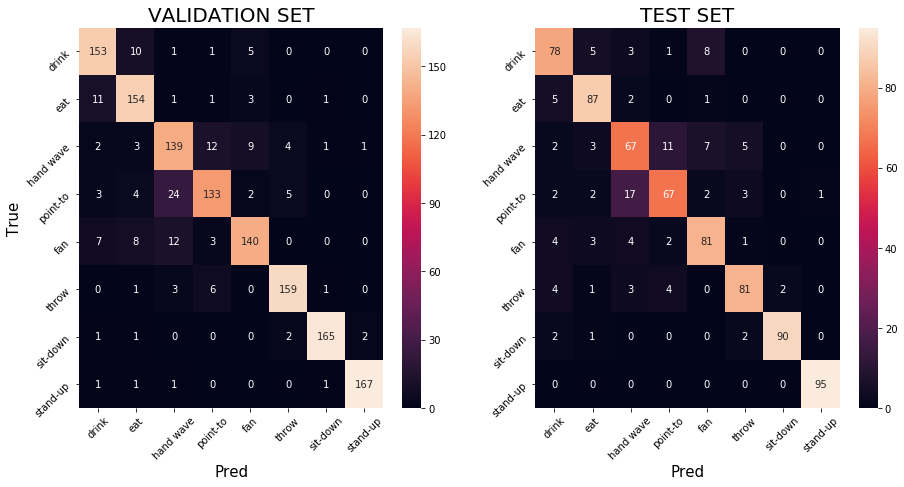

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Val acc: 0.27912087912087913
Test acc: 0.27140974967061926


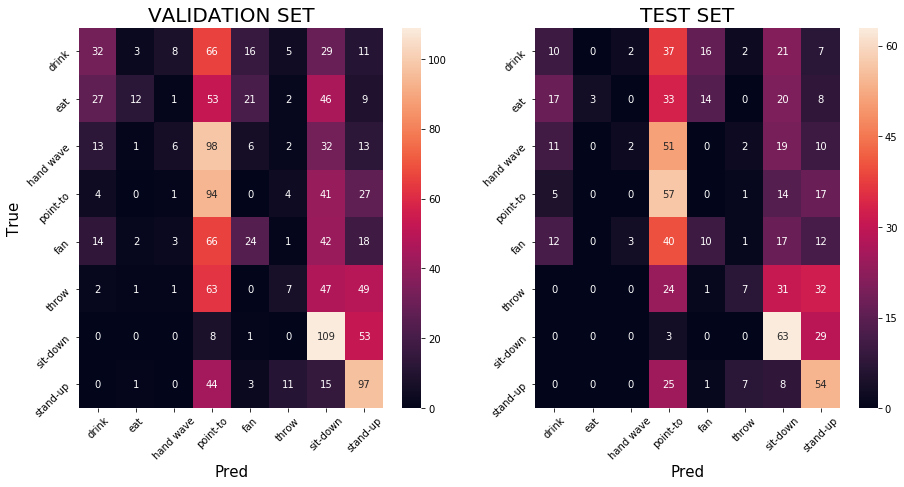

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame


KeyboardInterrupt: 

In [15]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        ## reshaping ###
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
        results.append((val_acc,test_acc,saved_model))

In [14]:
results

[(0.8864468864468864,
  0.8511198945981555,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5'>),
 (0.27912087912087913,
  0.27140974967061926,
  <DirEntry 'PoseNet-101-relativeToVideoCenter.h5'>),
 (0.8827838827838828,
  0.8313570487483531,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame.h5'>),
 (0.2293040293040293,
  0.21080368906455862,
  <DirEntry 'PoseNet-101-relativeToFrameCenter.h5'>),
 (0.1326007326007326,
  0.13175230566534915,
  <DirEntry 'PoseNet-101-relativeToVideoCenter-norm.h5'>),
 (0.18315018315018314,
  0.18972332015810275,
  <DirEntry 'PoseNet-101-relativeToFrameCenter-norm.h5'>),
 (0.8842490842490842,
  0.8642951251646904,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame-norm.h5'>),
 (0.28644688644688643,
  0.29907773386034253,
  <DirEntry 'PoseNet-101-relativeToNextFrame.h5'>),
 (0.21465201465201464, 0.2134387351778656, <DirEntry 'PoseNet-101-norm.h5'>),
 (0.136996336996337,
  0.13175230566534915,
  <DirEntry '

Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


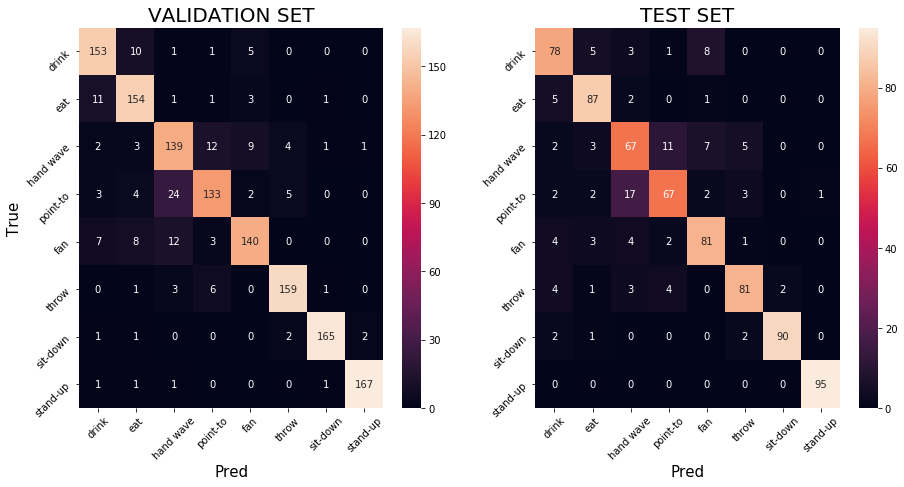

In [34]:
label_order = [1, 2, 31, 38, 49, 7, 8, 9]
model = loadedModel
y_val_pred = [label_order[i] for i in model.predict_classes(X_val)]
y_val_true = [label_order[np.argmax(i)] for i in y_val]
y_test_pred = [label_order[i] for i in model.predict_classes(X_test)]
y_test_true = [label_order[np.argmax(i)] for i in y_test]
val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
print("Val acc:",val_acc)
print("Test acc:",test_acc)
conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
plotConfusionMatrixes(conf_mat_val,conf_mat_test)

In [21]:
y_val_pred

[31,
 2,
 1,
 1,
 2,
 49,
 1,
 7,
 9,
 7,
 1,
 38,
 2,
 8,
 7,
 8,
 1,
 9,
 8,
 2,
 38,
 2,
 38,
 2,
 1,
 1,
 31,
 38,
 31,
 2,
 49,
 31,
 7,
 1,
 31,
 49,
 31,
 31,
 9,
 8,
 49,
 31,
 7,
 2,
 49,
 49,
 38,
 38,
 49,
 9,
 31,
 49,
 2,
 31,
 38,
 7,
 49,
 31,
 1,
 49,
 1,
 38,
 8,
 7,
 31,
 49,
 9,
 9,
 8,
 8,
 7,
 8,
 2,
 7,
 49,
 7,
 2,
 8,
 7,
 7,
 1,
 7,
 31,
 8,
 2,
 7,
 2,
 31,
 31,
 8,
 38,
 9,
 38,
 2,
 9,
 31,
 7,
 8,
 38,
 2,
 31,
 8,
 7,
 49,
 31,
 8,
 49,
 8,
 1,
 38,
 9,
 8,
 2,
 49,
 8,
 38,
 9,
 2,
 49,
 31,
 38,
 38,
 1,
 7,
 31,
 7,
 49,
 49,
 9,
 49,
 8,
 1,
 49,
 9,
 31,
 1,
 1,
 1,
 8,
 7,
 8,
 49,
 9,
 1,
 7,
 8,
 31,
 2,
 38,
 2,
 31,
 8,
 8,
 7,
 2,
 7,
 38,
 49,
 31,
 8,
 49,
 8,
 49,
 49,
 38,
 7,
 9,
 9,
 38,
 7,
 2,
 8,
 2,
 9,
 38,
 8,
 8,
 8,
 7,
 49,
 9,
 8,
 2,
 8,
 31,
 8,
 9,
 38,
 8,
 38,
 31,
 49,
 9,
 8,
 9,
 31,
 49,
 2,
 31,
 1,
 9,
 38,
 8,
 1,
 8,
 8,
 7,
 49,
 1,
 9,
 1,
 38,
 8,
 1,
 8,
 9,
 2,
 49,
 2,
 8,
 1,
 2,
 7,
 1,
 2,
 38,
 49,
 2,
 31,

In [128]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = getValTestAccuracy(loadedModel, X_val, y_val, X_test, y_test)
        print("Validation accuracy:",val_acc,"\nTest accuracy:",test_acc)
        results.append((basename(saved_model),val_acc, test_acc))
#         plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
print("DONE!")

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Validation accuracy: 0.8688644688644689 
Test accuracy: 0.8511198945981555
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each vid

In [114]:
loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)

## continue training

In [13]:
# modelName = 'simple-model.h5'

In [14]:
# from keras.models import load_model
# model = load_model(modelName)

#Continue training
# model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)

# model_history = model.fit(X_train, y_train,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
# #                     validation_split=0.2
#                     validation_data=(X_val, y_val)
#                    )

Train on 5460 samples, validate on 1365 samples
Epoch 1/10
5460/5460 [==============================] - 35s 6ms/step - loss: 1.2101 - accuracy: 0.4623 - val_loss: 1.2212 - val_accuracy: 0.4718
Epoch 2/10
 368/5460 [=>............................] - ETA: 29s - loss: 1.1121 - accuracy: 0.4810

KeyboardInterrupt: 

# Display classification

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_order = [1, 2, 31, 38, 49, 7, 8, 9]
y_pred = loadedModel.predict_classes(X_val)
# label_order = ["1", "2", "31", "38", "49", "7", "8", "9"]
y_pred_labels = [label_order[i] for i in y_pred]
y_val_labels = [label_order[np.argmax(i)] for i in y_val]

In [45]:
accuracy_score(y_pred=y_pred_labels,y_true=y_val_labels)

0.8827838827838828

In [46]:
yTrue=y_pred_labels
yPred=y_test_labels
conf_mat = confusion_matrix(y_true=yTrue, y_pred=yPred, labels=label_order)
conf_mat

array([[133,  16,   4,   4,   8,   0,   0,   0],
       [ 10, 110,   4,   1,  12,   2,   0,   0],
       [  3,   5, 130,   8,   3,   4,   0,   0],
       [  6,   1,   2, 108,   6,   1,   1,   0],
       [  3,   4,   2,   1, 113,   1,   0,   0],
       [  0,   0,   3,   2,   0, 119,   0,   1],
       [  0,   0,   1,   0,   1,   2, 130,   0],
       [  0,   0,   1,   0,   0,   1,   4, 121]])

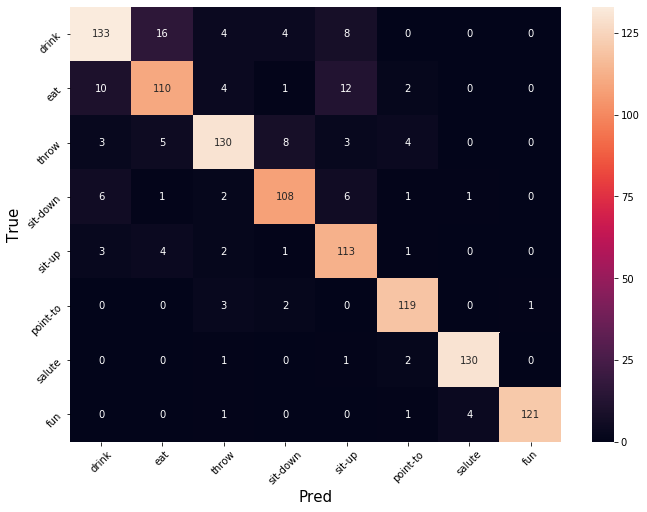

In [41]:
import seaborn as sn
plt.figure(figsize = (11,8))
ax = plt.axes()
labelString = ["drink", "eat", "throw", "sit-down", "sit-up", "point-to", "salute", "fun"]
ax = sn.heatmap(conf_mat, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# plt.title('', fontsize = 20) # title with fontsize 20
plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# ACTION_LABEL_SET = 
# A001  - A002 - A007 - A008     - A009   - A031               - A038   -  A049
# drink - eat - throw - sit down - sit up - point to something - salute - make a fun 


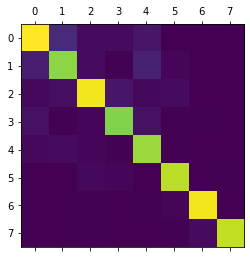

In [42]:
plt.matshow(conf_mat)